### Data Dictionary

The people of New Yorker use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their  questions:

- Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?
- Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?
- Does the Complaint Type that you identified in response to question 1 have an obvious relationship with any particular characteristic or characteristics of the houses or buildings?
- Can a predictive model be built for a future prediction of the possibility of complaints of the type that you have identified in response to question 1?


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.25)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [2]:
df = pd.read_csv("ServiceRequests.csv")

In [3]:
df

,Unnamed: 0,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,Incident Address,Street Name,Address Type,City,Status,Resolution Description,Borough,Latitude,Longitude
0,0,45531130,02/02/2020 06:09:17 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10019.0,426 WEST 52 STREET,WEST 52 STREET,ADDRESS,NEW YORK,Open,The following complaint conditions are still o...,MANHATTAN,40.765132,-73.988993
1,1,45529784,02/02/2020 02:15:24 PM,NaN,UNSANITARY CONDITION,RESIDENTIAL BUILDING,11204.0,1751 67 STREET,67 STREET,ADDRESS,BROOKLYN,Open,The following complaint conditions are still o...,BROOKLYN,40.618484,-73.992673
2,2,45527528,02/02/2020 02:27:41 AM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,11372.0,87-15 37 AVENUE,37 AVENUE,ADDRESS,Jackson Heights,Open,The following complaint conditions are still o...,QUEENS,40.750269,-73.879432
3,3,45530329,02/02/2020 12:13:18 PM,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10458.0,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,ADDRESS,BRONX,Open,The following complaint conditions are still o...,BRONX,40.853773,-73.881558
4,4,45528814,02/02/2020 01:59:44 PM,NaN,APPLIANCE,RESIDENTIAL BUILDING,11209.0,223 78 STREET,78 STREET,ADDRESS,BROOKLYN,Open,The following complaint conditions are still o...,BROOKLYN,40.629745,-74.030533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6019838,6019838,44063685,10/15/2019 10:35:45 AM,10/16/2019 05:55:02 PM,HEAT/HOT WATER,RESIDENTIAL BUILDING,10029.0,327 EAST 108 STREET,EAST 108 STREET,ADDRESS,NEW YORK,Closed,The complaint you filed is a duplicate of a co...,MANHATTAN,40.791359,-73.940184
6019839,6019839,44063692,10/15/2019 06:09:28 AM,10/15/2019 04:12:58 PM,HEAT/HOT WATER,RESIDENTIAL BUILDING,10461.0,3555 BRUCKNER BOULEVARD,BRUCKNER BOULEVARD,ADDRESS,BRONX,Closed,The Department of Housing Preservation and Dev...,BRONX,40.847809,-73.827481
6019840,6019840,44063724,10/15/2019 10:54:45 AM,10/16/2019 06:14:29 PM,HEAT/HOT WATER,RESIDENTIAL BUILDING,10034.0,165 SHERMAN AVENUE,SHERMAN AVENUE,ADDRESS,NEW YORK,Closed,The complaint you filed is a duplicate of a co...,MANHATTAN,40.864764,-73.922764
6019841,6019841,44063726,10/15/2019 02:07:34 PM,10/16/2019 07:10:19 PM,HEAT/HOT WATER,RESIDENTIAL BUILDING,10467.0,66 WEST GUN HILL ROAD,WEST GUN HILL ROAD,ADDRESS,BRONX,Closed,The Department of Housing Preservation and Dev...,BRONX,40.883207,-73.884279


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019843 entries, 0 to 6019842
Data columns (total 16 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unnamed: 0              int64  
 1   Unique Key              int64  
 2   Created Date            object 
 3   Closed Date             object 
 4   Complaint Type          object 
 5   Location Type           object 
 6   Incident Zip            float64
 7   Incident Address        object 
 8   Street Name             object 
 9   Address Type            object 
 10  City                    object 
 11  Status                  object 
 12  Resolution Description  object 
 13  Borough                 object 
 14  Latitude                float64
 15  Longitude               float64
dtypes: float64(3), int64(2), object(11)
memory usage: 734.8+ MB


In [5]:
df.describe(include='all')

,Unnamed: 0,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,Incident Address,Street Name,Address Type,City,Status,Resolution Description,Borough,Latitude,Longitude
count,6.019843e+06,6.019843e+06,6019843,5893186,6019843,5967019,5.939146e+06,5967018,5967018,5935078,5939569,6019843,6012017,6019843,5.939172e+06,5.939172e+06
unique,NaN,NaN,1675132,757706,30,5,NaN,182600,6825,1,89,5,340,6,NaN,NaN
top,NaN,NaN,01/24/2013 12:00:00 AM,11/07/2012 12:00:00 AM,HEAT/HOT WATER,RESIDENTIAL BUILDING,NaN,34 ARDEN STREET,GRAND CONCOURSE,ADDRESS,BROOKLYN,Closed,The Department of Housing Preservation and Dev...,BROOKLYN,NaN,NaN
freq,NaN,NaN,7581,7296,1261574,5959910,NaN,14298,92450,5935078,2026580,5886253,1698990,1739886,NaN,NaN
mean,3.009921e+06,2.956254e+07,NaN,NaN,NaN,NaN,1.074698e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.075424e+01,-7.391986e+01
std,1.737779e+06,7.909439e+06,NaN,NaN,NaN,NaN,5.130236e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.087877e-02,5.684804e-02
min,0.000000e+00,1.562973e+07,NaN,NaN,NaN,NaN,1.000100e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.049934e+01,-7.425312e+01
25%,1.504960e+06,2.291225e+07,NaN,NaN,NaN,NaN,1.045200e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.067116e+01,-7.395200e+01
50%,3.009921e+06,2.931010e+07,NaN,NaN,NaN,NaN,1.046900e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.075703e+01,-7.392248e+01
75%,4.514882e+06,3.583163e+07,NaN,NaN,NaN,NaN,1.122300e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.083958e+01,-7.389023e+01


In [6]:
df.shape

(6019843, 16)

In [7]:
df.columns

Index(['Unnamed: 0', 'Unique Key', 'Created Date', 'Closed Date',
       'Complaint Type', 'Location Type', 'Incident Zip', 'Incident Address',
       'Street Name', 'Address Type', 'City', 'Status',
       'Resolution Description', 'Borough', 'Latitude', 'Longitude'],
      dtype='object')

In [8]:
df.drop(['Unnamed: 0', 'Unique Key', 'Created Date', 'Closed Date','Address Type','Resolution Description',
        'Latitude', 'Longitude'],axis=1,inplace=True)

In [9]:
df

,Complaint Type,Location Type,Incident Zip,Incident Address,Street Name,City,Status,Borough
0,HEAT/HOT WATER,RESIDENTIAL BUILDING,10019.0,426 WEST 52 STREET,WEST 52 STREET,NEW YORK,Open,MANHATTAN
1,UNSANITARY CONDITION,RESIDENTIAL BUILDING,11204.0,1751 67 STREET,67 STREET,BROOKLYN,Open,BROOKLYN
2,HEAT/HOT WATER,RESIDENTIAL BUILDING,11372.0,87-15 37 AVENUE,37 AVENUE,Jackson Heights,Open,QUEENS
3,HEAT/HOT WATER,RESIDENTIAL BUILDING,10458.0,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,BRONX,Open,BRONX
4,APPLIANCE,RESIDENTIAL BUILDING,11209.0,223 78 STREET,78 STREET,BROOKLYN,Open,BROOKLYN
...,...,...,...,...,...,...,...,...
6019838,HEAT/HOT WATER,RESIDENTIAL BUILDING,10029.0,327 EAST 108 STREET,EAST 108 STREET,NEW YORK,Closed,MANHATTAN
6019839,HEAT/HOT WATER,RESIDENTIAL BUILDING,10461.0,3555 BRUCKNER BOULEVARD,BRUCKNER BOULEVARD,BRONX,Closed,BRONX
6019840,HEAT/HOT WATER,RESIDENTIAL BUILDING,10034.0,165 SHERMAN AVENUE,SHERMAN AVENUE,NEW YORK,Closed,MANHATTAN
6019841,HEAT/HOT WATER,RESIDENTIAL BUILDING,10467.0,66 WEST GUN HILL ROAD,WEST GUN HILL ROAD,BRONX,Closed,BRONX


In [10]:
df['Complaint Type'].value_counts()

HEAT/HOT WATER            1261574
HEATING                    887850
PLUMBING                   711130
GENERAL CONSTRUCTION       500863
UNSANITARY CONDITION       451643
PAINT - PLASTER            361257
PAINT/PLASTER              346438
ELECTRIC                   307310
NONCONST                   260890
DOOR/WINDOW                205278
WATER LEAK                 193631
GENERAL                    151308
FLOORING/STAIRS            137402
APPLIANCE                  112831
HPD Literature Request      52824
SAFETY                      51529
OUTSIDE BUILDING             7142
ELEVATOR                     6725
Unsanitary Condition         5499
CONSTRUCTION                 5078
General                      1163
Safety                        424
STRUCTURAL                     16
Plumbing                       11
AGENCY                          9
VACANT APARTMENT                6
Outside Building                6
Appliance                       4
Electric                        1
Mold          

Top Complaint are HEAT/HOT WATER + HEATING

In [11]:
df['Location Type'].value_counts()

RESIDENTIAL BUILDING    5959910
Residential Building       7098
Apartment                     5
Building-Wide                 4
Public Area                   2
Name: Location Type, dtype: int64

In [12]:
df['Incident Zip'].value_counts()

11226.0    215709
10467.0    173911
10458.0    169485
10453.0    162532
10468.0    148213
            ...  
10271.0         1
10279.0         1
11243.0         1
10045.0         1
12345.0         1
Name: Incident Zip, Length: 202, dtype: int64

In [13]:
df['Incident Address'].value_counts()

34 ARDEN STREET          14298
89-21 ELMHURST AVENUE    12823
1025 BOYNTON AVENUE       9878
3810 BAILEY AVENUE        7174
9511 SHORE ROAD           5062
                         ...  
1264 BERGEN STREET           1
9622 KINGS HIGHWAY           1
253 WYONA STREET             1
973 HOPKINSON AVENUE         1
979 EAST 163 STREET          1
Name: Incident Address, Length: 182600, dtype: int64

In [14]:
df['Street Name'].value_counts()

GRAND CONCOURSE       92450
BROADWAY              65592
OCEAN AVENUE          55303
ST NICHOLAS AVENUE    41525
MORRIS AVENUE         40804
                      ...  
LINCOLN PL                1
VAN WYCK AVENUE           1
MAYFIELD ROAD             1
ANITA STREET              1
KENO AVENUE               1
Name: Street Name, Length: 6825, dtype: int64

In [15]:
df['City'].value_counts()

BROOKLYN         2026580
BRONX            1860522
NEW YORK         1204417
STATEN ISLAND     101553
Jamaica            65977
                  ...   
Floral Park          208
New Hyde Park         90
FLORAL PARK           79
BREEZY POINT          53
NEW HYDE PARK         22
Name: City, Length: 89, dtype: int64

In [16]:
df['Status'].value_counts()

Closed         5886253
Open            133220
In Progress        364
Assigned             4
Pending              2
Name: Status, dtype: int64

In [17]:
df['Borough'].value_counts()

BROOKLYN         1739886
BRONX            1617956
MANHATTAN        1055225
Unspecified       873221
QUEENS            645971
STATEN ISLAND      87584
Name: Borough, dtype: int64

In [18]:
df.columns

Index(['Complaint Type', 'Location Type', 'Incident Zip', 'Incident Address',
       'Street Name', 'City', 'Status', 'Borough'],
      dtype='object')

In [19]:
df.rename(columns={'Complaint Type':'ComplaintType','Location Type':'LocationType','Incident Zip':'Zipcode',
         'Incident Address':'Address','Street Name':'Street'},inplace=True)

In [20]:
df

,ComplaintType,LocationType,Zipcode,Address,Street,City,Status,Borough
0,HEAT/HOT WATER,RESIDENTIAL BUILDING,10019.0,426 WEST 52 STREET,WEST 52 STREET,NEW YORK,Open,MANHATTAN
1,UNSANITARY CONDITION,RESIDENTIAL BUILDING,11204.0,1751 67 STREET,67 STREET,BROOKLYN,Open,BROOKLYN
2,HEAT/HOT WATER,RESIDENTIAL BUILDING,11372.0,87-15 37 AVENUE,37 AVENUE,Jackson Heights,Open,QUEENS
3,HEAT/HOT WATER,RESIDENTIAL BUILDING,10458.0,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,BRONX,Open,BRONX
4,APPLIANCE,RESIDENTIAL BUILDING,11209.0,223 78 STREET,78 STREET,BROOKLYN,Open,BROOKLYN
...,...,...,...,...,...,...,...,...
6019838,HEAT/HOT WATER,RESIDENTIAL BUILDING,10029.0,327 EAST 108 STREET,EAST 108 STREET,NEW YORK,Closed,MANHATTAN
6019839,HEAT/HOT WATER,RESIDENTIAL BUILDING,10461.0,3555 BRUCKNER BOULEVARD,BRUCKNER BOULEVARD,BRONX,Closed,BRONX
6019840,HEAT/HOT WATER,RESIDENTIAL BUILDING,10034.0,165 SHERMAN AVENUE,SHERMAN AVENUE,NEW YORK,Closed,MANHATTAN
6019841,HEAT/HOT WATER,RESIDENTIAL BUILDING,10467.0,66 WEST GUN HILL ROAD,WEST GUN HILL ROAD,BRONX,Closed,BRONX


In [21]:
#Save as csv
#df.to_csv('partone.csv',index=False)

### Data Visualization

### Univariate Data Exploration

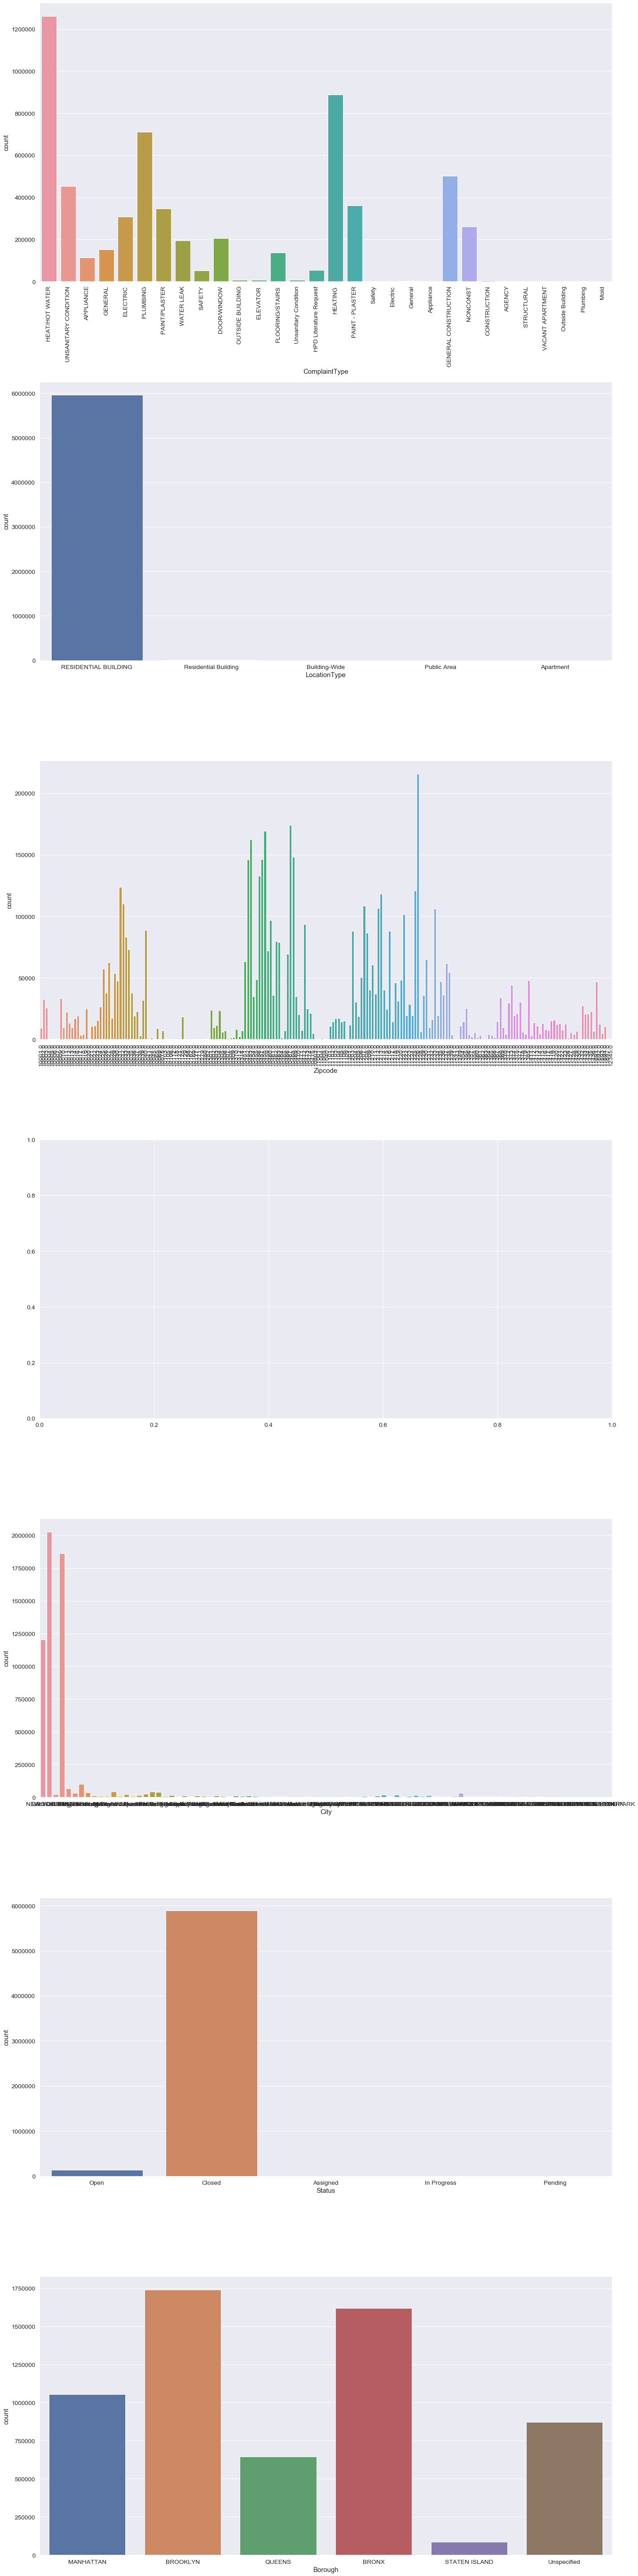

In [22]:
fig = plt.figure(figsize=(20,80))

plt.subplot(7,1,1)
sns.countplot(df.ComplaintType)
plt.xticks(rotation=90)
plt.subplot(7,1,2)
sns.countplot(df.LocationType)
plt.subplot(7,1,3)
sns.countplot(df.Zipcode)
plt.xticks(rotation=90)
plt.subplot(7,1,4)
#sns.countplot(df.Street)
plt.subplot(7,1,5)
sns.countplot(df.City)
plt.subplot(7,1,6)
sns.countplot(df.Status)
plt.subplot(7,1,7)
sns.countplot(df.Borough)
# plt.subplot(7,2,8)
# sns.countplot()
# plt.subplot(7,2,9)
# sns.countplot()
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [23]:
df2 = df.pivot_table(index=['Borough'],columns=['Street'],aggfunc='count',values=['ComplaintType'])

In [24]:
df2

ComplaintType                                              \
Street                1 AVE 1 AVENUE 1 COURT 1 PLACE 1 STREET 10 AVENUE   
Borough                                                                   
BRONX                   NaN      NaN     NaN     NaN      NaN       NaN   
BROOKLYN                NaN     27.0     1.0    73.0    207.0    1069.0   
MANHATTAN               NaN  13774.0     NaN     NaN      NaN    5849.0   
QUEENS                  NaN      NaN     NaN     NaN     29.0       6.0   
STATEN ISLAND           NaN      NaN     NaN     NaN      1.0       NaN   
Unspecified             1.0   1560.0     NaN     5.0     24.0     721.0   

                                                                             \
Street        10 STREET 100 AVENUE 100 DRIVE 100 ROAD 100 STREET 101 AVENUE   
Borough                                                                       
BRONX               NaN        NaN       NaN      NaN        NaN        NaN   
BROOKLYN          545.0        NaN       NaN      NaN      168.0        NaN   
MANHATTAN           NaN        NaN       NaN      NaN        NaN        NaN   
QUEENS             81.0      213.0       6.0      1.0      499.0     2362.0   
STATEN ISLAND       6.0        NaN       NaN      NaN        NaN        NaN   
Unspecified       167.0       23.0       3.0      NaN       90.0      452.0   

                                                                          \
Street        101 ROAD 101 STREET 102 AVE 102 AVENUE 102 ROAD 102 STREET   
Borough                                                                    
BRONX              NaN        NaN     NaN        NaN      NaN        NaN   
BROOKLYN           NaN      184.0     NaN        NaN      NaN        NaN   
MANHATTAN          NaN        NaN     NaN        NaN      NaN        NaN   
QUEENS             2.0      735.0     NaN     1050.0    260.0     2154.0   
STATEN ISLAND      NaN        NaN     NaN        NaN      NaN        NaN   
Unspecified       25.0      148.0     2.0      167.0     30.0      494.0   

                                                                              \
Street        103 AVENUE 103 DRIVE 103 ROAD 103 STREET 104 AVENUE 104 STREET   
Borough                                                                        
BRONX                NaN       NaN      NaN        NaN        NaN        NaN   
BROOKLYN             NaN       NaN      NaN        NaN        NaN        NaN   
MANHATTAN            NaN       NaN      NaN        NaN        NaN        NaN   
QUEENS             882.0      41.0    112.0     1517.0      400.0     1181.0   
STATEN ISLAND        NaN       NaN      NaN        NaN        NaN        NaN   
Unspecified        159.0       5.0     39.0      305.0       62.0      171.0   

                                                                               \
Street        105 AVENUE 105 STREET 106 AVENUE 106 ROAD 106 STREET 107 AVENUE   
Borough                                                                         
BRONX                NaN        NaN        NaN      NaN        NaN        NaN   
BROOKLYN             NaN        NaN        NaN      NaN        NaN        NaN   
MANHATTAN            NaN        NaN        NaN      NaN        NaN        NaN   
QUEENS            1166.0      387.0      852.0    234.0      505.0     1295.0   
STATEN ISLAND        NaN        NaN        NaN      NaN        NaN        NaN   
Unspecified        272.0       40.0      159.0     64.0       58.0      242.0   

                                                                          \
Street        107 ROAD 107 ST 107 STREET 108 AVENUE 108 DRIVE 108 STREET   
Borough                                                                    
BRONX              NaN    NaN        NaN        NaN       NaN        NaN   
BROOKLYN           NaN    NaN        NaN        NaN       NaN        NaN   
MANHATTAN          NaN    NaN        NaN        NaN       NaN        NaN   
QUEENS            14.0    NaN     

In [25]:
df3 = df.pivot_table(index=['Street'],columns=['Zipcode'],aggfunc='count',values=['ComplaintType'])

In [26]:
df3

ComplaintType                                                  \
Zipcode              10001.0 10002.0 10003.0 10004.0 10005.0 10006.0 10007.0   
Street                                                                         
1 AVENUE                 NaN     NaN  1185.0     NaN     NaN     NaN     NaN   
1 COURT                  NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1 PLACE                  NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1 STREET                 NaN     NaN     NaN     NaN     NaN     NaN     NaN   
10 AVENUE              712.0     NaN     NaN     NaN     NaN     NaN     NaN   
...                      ...     ...     ...     ...     ...     ...     ...   
ZEREGA AVENUE            NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZION STREET              NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZOE STREET               NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZOLLER ROAD              NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZULETTE AVENUE           NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                                                                        \
Zipcode        10009.0 10010.0 10011.0 10012.0 10013.0 10014.0 10016.0   
Street                                                                   
1 AVENUE        1938.0   532.0     NaN     NaN     NaN     NaN   255.0   
1 COURT            NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1 PLACE            NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1 STREET           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
10 AVENUE          NaN     NaN   434.0     NaN     NaN     3.0     NaN   
...                ...     ...     ...     ...     ...     ...     ...   
ZEREGA AVENUE      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZION STREET        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZOE STREET         NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZOLLER ROAD        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZULETTE AVENUE     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                                                                        \
Zipcode        10017.0 10018.0 10019.0 10020.0 10021.0 10022.0 10023.0   
Street                                                                   
1 AVENUE          34.0     NaN     NaN     NaN  1183.0  1805.0     NaN   
1 COURT            NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1 PLACE            NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1 STREET           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
10 AVENUE          NaN    50.0  1764.0     NaN     NaN     NaN     NaN   
...                ...     ...     ...     ...     ...     ...     ...   
ZEREGA AVENUE      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZION STREET        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZOE STREET         NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZOLLER ROAD        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZULETTE AVENUE     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                                                                        \
Zipcode        10024.0 10025.0 10026.0 10027.0 10028.0 10029.0 10030.0   
Street                                                                   
1 AVENUE           NaN     NaN     NaN     NaN   686.0  3491.0     NaN   
1 COURT            NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1 PLACE            NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1 STREET           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
10 AVENUE          NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...                ...     ...     ...     ...     ...     ...     ...   
ZEREGA AVENUE      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZION STREET        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZOE ST

In [27]:
df.corr()

,Zipcode
Zipcode,1.0


### Data Preprocessing

### Treat Missing Values

In [28]:
df.isnull().sum()

ComplaintType        0
LocationType     52824
Zipcode          80697
Address          52825
Street           52825
City             80274
Status               0
Borough              0
dtype: int64

In [29]:
df.dropna(inplace=True)

In [30]:
df.isnull().sum()

ComplaintType    0
LocationType     0
Zipcode          0
Address          0
Street           0
City             0
Status           0
Borough          0
dtype: int64

### Treat Duplicate Values

In [31]:
df.duplicated(keep='first').sum()

5009110

In [32]:
df[df.duplicated(keep=False)]

,ComplaintType,LocationType,Zipcode,Address,Street,City,Status,Borough
1,UNSANITARY CONDITION,RESIDENTIAL BUILDING,11204.0,1751 67 STREET,67 STREET,BROOKLYN,Open,BROOKLYN
5,HEAT/HOT WATER,RESIDENTIAL BUILDING,10456.0,1131 MORRIS AVENUE,MORRIS AVENUE,BRONX,Open,BRONX
7,HEAT/HOT WATER,RESIDENTIAL BUILDING,11372.0,37-20 81 STREET,81 STREET,Jackson Heights,Open,QUEENS
8,ELECTRIC,RESIDENTIAL BUILDING,11230.0,679 OCEAN PARKWAY,OCEAN PARKWAY,BROOKLYN,Open,BROOKLYN
10,HEAT/HOT WATER,RESIDENTIAL BUILDING,10459.0,1032 ALDUS STREET,ALDUS STREET,BRONX,Open,BRONX
...,...,...,...,...,...,...,...,...
6019838,HEAT/HOT WATER,RESIDENTIAL BUILDING,10029.0,327 EAST 108 STREET,EAST 108 STREET,NEW YORK,Closed,MANHATTAN
6019839,HEAT/HOT WATER,RESIDENTIAL BUILDING,10461.0,3555 BRUCKNER BOULEVARD,BRUCKNER BOULEVARD,BRONX,Closed,BRONX
6019840,HEAT/HOT WATER,RESIDENTIAL BUILDING,10034.0,165 SHERMAN AVENUE,SHERMAN AVENUE,NEW YORK,Closed,MANHATTAN
6019841,HEAT/HOT WATER,RESIDENTIAL BUILDING,10467.0,66 WEST GUN HILL ROAD,WEST GUN HILL ROAD,BRONX,Closed,BRONX


### Treat Outliers

In [33]:
df.columns

Index(['ComplaintType', 'LocationType', 'Zipcode', 'Address', 'Street', 'City',
       'Status', 'Borough'],
      dtype='object')

### Treat Data Types

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5939146 entries, 0 to 6019842
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ComplaintType  object 
 1   LocationType   object 
 2   Zipcode        float64
 3   Address        object 
 4   Street         object 
 5   City           object 
 6   Status         object 
 7   Borough        object 
dtypes: float64(1), object(7)
memory usage: 407.8+ MB


In [35]:
df['Zipcode'] = df['Zipcode'].astype("object")

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5939146 entries, 0 to 6019842
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ComplaintType  object
 1   LocationType   object
 2   Zipcode        object
 3   Address        object
 4   Street         object
 5   City           object
 6   Status         object
 7   Borough        object
dtypes: object(8)
memory usage: 407.8+ MB


### Drop unwanted features

In [37]:
df.columns

Index(['ComplaintType', 'LocationType', 'Zipcode', 'Address', 'Street', 'City',
       'Status', 'Borough'],
      dtype='object')

In [38]:
df.drop(['LocationType','Address','Status','City'],axis=1,inplace=True)

In [39]:
df

,ComplaintType,Zipcode,Street,Borough
0,HEAT/HOT WATER,10019,WEST 52 STREET,MANHATTAN
1,UNSANITARY CONDITION,11204,67 STREET,BROOKLYN
2,HEAT/HOT WATER,11372,37 AVENUE,QUEENS
3,HEAT/HOT WATER,10458,SOUTHERN BOULEVARD,BRONX
4,APPLIANCE,11209,78 STREET,BROOKLYN
...,...,...,...,...
6019838,HEAT/HOT WATER,10029,EAST 108 STREET,MANHATTAN
6019839,HEAT/HOT WATER,10461,BRUCKNER BOULEVARD,BRONX
6019840,HEAT/HOT WATER,10034,SHERMAN AVENUE,MANHATTAN
6019841,HEAT/HOT WATER,10467,WEST GUN HILL ROAD,BRONX


### Create and save processed dataset

In [40]:
#df.to_csv("partone.csv",index=False)